# Modeling and Tuning


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pipelines import merge_application_with_credit
import pandas as pd
from pipelines import unified_pipeline

ap_df = pd.read_csv("application_train_train.csv")
cr_df = pd.read_csv("credit_card_balance.csv")
ap_val_df = pd.read_csv("application_train_val.csv")

### I will be creating another split in the data to evaluate a meta-model on

ap_val_df, meta_val_df = train_test_split(
    ap_val_df, 
    test_size=0.3,  
    stratify=ap_val_df["TARGET"],  # Ensures balanced class distribution in both splits
    random_state=42
)


ap_df = unified_pipeline(ap_df, cr_df, include_target=True)
ap_val_df = unified_pipeline(ap_val_df, cr_df, include_target=True)
meta_val_df = unified_pipeline(meta_val_df, cr_df, include_target=True)


c:\Users\david\Projects\Credit_Risk_Project\pipelines.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna('Unknown', inplace=True)
c:\Users\david\Projects\Credit_Risk_Project\pipelines.py:116: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[

In [13]:


# Verify shapes after pipelines
print("Processed Train Shape:", ap_df.shape)
print("Processed Validation Shape:", ap_val_df.shape)

# Check if columns are the same in both DataFrames
if not ap_df.columns.equals(ap_val_df.columns):
    print("Columns mismatch detected - it's over so </3")
else:
    print("Column check passed - we're fine to proceed")




Processed Train Shape: (58690, 41)
Processed Validation Shape: (17389, 41)
Column check passed - we're fine to proceed


# Baseline Model Evaluation



In [14]:
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

# Prepare feature and target data for train and validation sets
X_train = ap_df.drop(columns=['TARGET'])
y_train = ap_df['TARGET']
X_val = ap_val_df.drop(columns=['TARGET'])
y_val = ap_val_df['TARGET']

# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(is_unbalance=True, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Balanced Bagging Classifier': BaggingClassifier(
        estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Use predicted probabilities for AUC

    # Calculate metrics
    auc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    return {
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    metrics = evaluate_model(model, X_train, y_train, X_val, y_val)
    results[model_name] = metrics
    print(f"Results for {model_name}: {metrics}")

# Convert results to DataFrame
results_df = pd.DataFrame(results).T  # Transpose to get models as rows
print("\nFinal Evaluation Results:\n", results_df)


Training Logistic Regression...
Results for Logistic Regression: {'AUC': np.float64(0.7655941691775809), 'Precision': np.float64(0.1790724542003631), 'Recall': np.float64(0.7228514323784144), 'F1 Score': np.float64(0.28703703703703703)}
Training Random Forest...
Results for Random Forest: {'AUC': np.float64(0.7373695314234955), 'Precision': np.float64(0.5384615384615384), 'Recall': np.float64(0.009327115256495669), 'F1 Score': np.float64(0.0183366077275704)}
Training XGBoost...


c:\Users\david\Projects\Credit_Risk_Project\Credit_Risk_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results for XGBoost: {'AUC': np.float64(0.7070978780175419), 'Precision': np.float64(0.22056384742951907), 'Recall': np.float64(0.35443037974683544), 'F1 Score': np.float64(0.27191413237924866)}
Training LightGBM...
[LightGBM] [Info] Number of positive: 5109, number of negative: 53581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7361
[LightGBM] [Info] Number of data points in the train set: 58690, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087051 -> initscore=-2.350191
[LightGBM] [Info] Start training from score -2.350191
Results for LightGBM: {'AUC': np.float64(0.7628473011949738), 'Precision': np.float64(0.20140515222482436), 'Recall': np.float64(0.6302465023317788), 'F1 Score': np.float64(0.3052597612132946)}
Training AdaBoost...


c:\Users\david\Projects\Credit_Risk_Project\Credit_Risk_venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost: {'AUC': np.float64(0.7576713082516991), 'Precision': np.float64(0.514018691588785), 'Recall': np.float64(0.03664223850766156), 'F1 Score': np.float64(0.06840796019900497)}
Training Balanced Bagging Classifier...
Results for Balanced Bagging Classifier: {'AUC': np.float64(0.7650654850442103), 'Precision': np.float64(0.17853593905266646), 'Recall': np.float64(0.7181878747501665), 'F1 Score': np.float64(0.28597957288765086)}
Training Gradient Boosting...
Results for Gradient Boosting: {'AUC': np.float64(0.764863454575097), 'Precision': np.float64(0.5161290322580645), 'Recall': np.float64(0.031978680879413725), 'F1 Score': np.float64(0.060225846925972396)}

Final Evaluation Results:
                                   AUC  Precision    Recall  F1 Score
Logistic Regression          0.765594   0.179072  0.722851  0.287037
Random Forest                0.737370   0.538462  0.009327  0.018337
XGBoost                      0.707098   0.220564  0.354430  0.271914
LightGBM     

# Base Model Evaluation Summary

The following table compares the performance of various models based on **AUC**, **Precision**, **Recall**, and **F1 Score**. The focus is on achieving a balanced trade-off between **Precision** and **Recall**, particularly emphasizing the capture of positive cases.

| Model                       | AUC     | Precision | Recall  | F1 Score |
|-----------------------------|---------|-----------|---------|----------|
| **Logistic Regression**     | 0.7656  | 0.1791    | 0.7229  | 0.2870   |
| **Random Forest**           | 0.7374  | 0.5385    | 0.0093  | 0.0183   |
| **XGBoost**                 | 0.7071  | 0.2206    | 0.3544  | 0.2719   |
| **LightGBM**                | 0.7628  | 0.2014    | 0.6302  | 0.3053   |
| **AdaBoost**                | 0.7577  | 0.5140    | 0.0366  | 0.0684   |
| **Balanced Bagging Classifier** | 0.7651 | 0.1785 | 0.7182  | 0.2860   |
| **Gradient Boosting**       | 0.7649  | 0.5161    | 0.0320  | 0.0602   |

#### Key Observations
1. **Logistic Regression** and **Balanced Bagging Classifier** both have high **Recall** (0.7229 and 0.7182, respectively), with similar **Precision** (around 0.179), resulting in **F1 Scores** of 0.287 and 0.286. These models are suitable for recall-focused objectives.
2. **LightGBM** has the highest **F1 Score** (0.3053), balancing **Precision** (0.2014) and **Recall** (0.6302) effectively, making it the best overall option for capturing positive cases while maintaining reasonable precision.
3. **XGBoost** has a slightly lower **F1 Score** (0.2719) compared to LightGBM, with moderate recall (0.3544), making it an alternative to LightGBM when computational efficiency or interpretability of results is prioritized.
4. **Gradient Boosting**, **Random Forest**, and **AdaBoost** models provide higher **Precision** but very low **Recall** (all below 0.04), resulting in F1 Scores below 0.07. These models are less effective for recall-centric tasks, as they miss a significant portion of positive cases.

#### Conclusion
**LightGBM** remains the top choice for a balanced approach to **Precision** and **Recall**, especially in contexts where detecting positive cases is crucial. If prioritizing **Recall** alone, **Logistic Regression** and **Balanced Bagging Classifier** provide competitive alternatives. **Logistic Regression** could also be explored further in ensemble approaches to stabilize performance.


# What's the best way to handle imbalanced classes?

In [15]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import pandas as pd

# Prepare feature and target data for train and validation sets


# Function to evaluate models with resampling
def evaluate_model_with_resampling(model, X_train, y_train, X_val, y_val, sampling_strategy="undersample"):
    # Apply chosen sampling strategy to the training set only
    if sampling_strategy == "undersample":
        sampler = RandomUnderSampler(random_state=42)
    elif sampling_strategy == "oversample":
        sampler = RandomOverSampler(random_state=42)
    elif sampling_strategy == "smote":
        sampler = SMOTE(random_state=42)
    else:
        raise ValueError("Invalid sampling strategy. Choose from 'undersample', 'oversample', or 'smote'.")
        
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    
    # Fit the model on resampled training data
    model.fit(X_train_res, y_train_res)
    
    # Predict probabilities and labels on the validation set
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    auc = roc_auc_score(y_val, y_pred_prob)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Create a DataFrame to display metrics
    results_df = pd.DataFrame({
        "Metric": ["AUC Score", "Precision Score", "Recall Score", "F1 Score"],
        "Score": [auc, precision, recall, f1]
    })
    
    print(f"\nModel Evaluation with {sampling_strategy.capitalize()}:")
    print(results_df.to_string(index=False))

# Models to evaluate
logistic_regression = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
lightgbm = LGBMClassifier(class_weight="balanced", random_state=42)

# Evaluate Logistic Regression with different resampling methods
print("Logistic Regression - 1. Undersampling the Majority Class")
evaluate_model_with_resampling(logistic_regression, X_train, y_train, X_val, y_val, sampling_strategy="undersample")

print("\nLogistic Regression - 2. Oversampling the Minority Class")
evaluate_model_with_resampling(logistic_regression, X_train, y_train, X_val, y_val, sampling_strategy="oversample")

print("\nLogistic Regression - 3. SMOTE")
evaluate_model_with_resampling(logistic_regression, X_train, y_train, X_val, y_val, sampling_strategy="smote")

# Evaluate LightGBM with different resampling methods
print("\nLightGBM - 1. Undersampling the Majority Class")
evaluate_model_with_resampling(lightgbm, X_train, y_train, X_val, y_val, sampling_strategy="undersample")

print("\nLightGBM - 2. Oversampling the Minority Class")
evaluate_model_with_resampling(lightgbm, X_train, y_train, X_val, y_val, sampling_strategy="oversample")

print("\nLightGBM - 3. SMOTE")
evaluate_model_with_resampling(lightgbm, X_train, y_train, X_val, y_val, sampling_strategy="smote")


Logistic Regression - 1. Undersampling the Majority Class

Model Evaluation with Undersample:
         Metric    Score
      AUC Score 0.764746
Precision Score 0.178015
   Recall Score 0.722851
       F1 Score 0.285677

Logistic Regression - 2. Oversampling the Minority Class

Model Evaluation with Oversample:
         Metric    Score
      AUC Score 0.765553
Precision Score 0.179114
   Recall Score 0.722185
       F1 Score 0.287038

Logistic Regression - 3. SMOTE

Model Evaluation with Smote:
         Metric    Score
      AUC Score 0.724429
Precision Score 0.165581
   Recall Score 0.643571
       F1 Score 0.263395

LightGBM - 1. Undersampling the Majority Class
[LightGBM] [Info] Number of positive: 5109, number of negative: 5109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7172
[LightGBM] [Info] Number of data points in the train set: 10218

## Model Evaluation with Different Sampling Techniques and Baseline Scores for Logistic Regression and LightGBM

Below is a comparison of **Logistic Regression** and **LightGBM** models, both with and without sampling techniques. The resampling strategies include **Undersampling**, **Oversampling**, and **SMOTE**, with evaluations based on **AUC**, **Precision**, **Recall**, and **F1 Score**.

### Model Performance Comparison

| Model                   | Sampling       | AUC    | Precision | Recall  | F1 Score |
|-------------------------|----------------|--------|-----------|---------|----------|
| **Logistic Regression** | Baseline       | 0.7656 | 0.1791    | 0.7229  | 0.2870   |
|                         | Undersampling  | 0.7647 | 0.1780    | 0.7229  | 0.2857   |
|                         | Oversampling   | 0.7656 | 0.1791    | 0.7222  | 0.2870   |
|                         | SMOTE          | 0.7244 | 0.1656    | 0.6436  | 0.2634   |
| **LightGBM**            | Baseline       | 0.7628 | 0.2014    | 0.6302  | 0.3053   |
|                         | Undersampling  | 0.7563 | 0.1791    | 0.6822  | 0.2837   |
|                         | Oversampling   | 0.7591 | 0.2035    | 0.6056  | 0.3046   |
|                         | SMOTE          | 0.5901 | 0.0864    | 0.9993  | 0.1591   |

### Key Observations

1. **AUC Score**:
   - **Oversampling** and **Baseline** provide the highest AUC for **Logistic Regression** at **0.7656**.
   - **LightGBM** performs best with **Baseline** and **Oversampling**, achieving **0.7628** and **0.7591**, respectively.

2. **Precision**:
   - **Oversampling** yields the highest precision for **LightGBM** at **0.2035**, while **Logistic Regression** reaches **0.1791** with both **Baseline** and **Oversampling**.

3. **Recall**:
   - **SMOTE** produces nearly perfect recall with **LightGBM** (**0.9993**), suggesting potential overfitting to synthetic samples.
   - **Undersampling** and **Oversampling** for **Logistic Regression** maintain relatively high recall, balancing better between sensitivity and specificity.

4. **F1 Score**:
   - **Oversampling** yields the best F1 score for both models: **0.2870** for **Logistic Regression** and **0.3046** for **LightGBM**, indicating a good balance between recall and precision.

### Conclusion

**Oversampling** is the most balanced sampling approach for both **Logistic Regression** and **LightGBM**, achieving high scores across AUC, precision, recall, and F1. This method proves effective in managing the class imbalance while avoiding overfitting, as seen with **SMOTE** in **LightGBM**.


## Oversampling with Bagging (Logistic Regression)


In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd

tg = "TARGET"

# Separate features and target for pre-split train and validation data

# Define oversampling strategy
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

# Define BaggingClassifier with Logistic Regression as base estimator
base_estimator = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42)

# Fit the model on the oversampled training data
bagging_model.fit(X_train_over, y_train_over)

# Predict probabilities and labels on the validation set
y_pred_prob = bagging_model.predict_proba(X_val)[:, 1]
y_pred = bagging_model.predict(X_val)

# Calculate overall metrics
auc = roc_auc_score(y_val, y_pred_prob)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Create a summary DataFrame with overall metrics
results_df = pd.DataFrame({
    "Metric": ["AUC Score", "Precision Score (Overall)", "Recall Score (Overall)", "F1 Score (Overall)"],
    "Score": [auc, precision, recall, f1]
})

# Display results
print("\nLogistic Regression Bagging Model Evaluation with Oversampling:")
print(results_df.to_string(index=False))



Logistic Regression Bagging Model Evaluation with Oversampling:
                   Metric    Score
                AUC Score 0.765528
Precision Score (Overall) 0.179406
   Recall Score (Overall) 0.720853
       F1 Score (Overall) 0.287307


## Comparison of Logistic Regression with and without Bagging using Oversampling

The following table compares the performance of **Logistic Regression** and **Logistic Regression with Bagging** when oversampling is applied. The metrics include **AUC**, **Precision**, **Recall**, and **F1 Score**.

#### Model Performance: Logistic Regression vs. Logistic Regression with Bagging

| Model                                    | AUC Score | Precision | Recall  | F1 Score |
|------------------------------------------|-----------|-----------|---------|----------|
| **Logistic Regression (Oversampling)**   | 0.7617    | 0.1815    | 0.6911  | 0.2875   |
| **Logistic Regression with Bagging (Oversampling)** | 0.7617    | 0.1809    | 0.6859  | 0.2862   |

#### Key Observations

1. **AUC Score**:
   - Both models have nearly identical AUC scores, with **Logistic Regression (Oversampling)** at **0.7617** and **Logistic Regression with Bagging (Oversampling)** at **0.7617**. This indicates that bagging does not impact AUC in this case.

2. **Precision**:
   - Precision is slightly higher without bagging (**0.1815**) compared to the bagging model (**0.1809**), showing minimal impact from bagging on the model's positive predictive accuracy.

3. **Recall**:
   - **Logistic Regression (Oversampling)** achieves a slightly higher recall (**0.6911**) than the bagging model (**0.6859**), suggesting that bagging marginally reduces the model's sensitivity to the minority class.

4. **F1 Score**:
   - The F1 score is marginally higher without bagging (**0.2875** vs. **0.2862** with bagging), reflecting a small improvement in the balance between precision and recall without bagging.

**Conclusion**:
- **Logistic Regression with Oversampling (No Bagging)** slightly outperforms the bagging model in all metrics, especially in recall and F1 score. The differences are minimal, indicating that bagging does not provide substantial improvements in this case. For simplicity and efficiency, the non-bagging model may


### Final Selection

Proceeding I will be utilising a logistic regression model as it is most optimal for maximum possible recall, I opted for this because the cost of a false positive is less than false negative in credit default prediction

### Note on Hyperparameter Optimization

I am fully aware of the importance and benefits of **hyperparameter optimization** in improving model performance. Techniques like **Grid Search** and **Randomized Search** can often enhance precision, recall, and overall model accuracy by tuning parameters to find the optimal configuration.

However, due to **hardware limitations**, my current laptop struggles with computationally intensive tasks. Even less resource-heavy methods, like **Randomized Search**, take a significant amount of time to complete. As a result, for this project, I opted to use **default or minimally tuned hyperparameters** to maintain a manageable workflow within the constraints of my system.

While this may limit the model’s absolute performance, it allows me to focus on demonstrating **modeling techniques, ensemble methods, and sampling strategies**. Future work on more powerful hardware could include full hyperparameter optimization to further refine the model.


# Making a Meta Labeling Model



### Measures to Avoid Data Leakage and Overfitting

1. **Separate Training and Validation Sets**: 
   We train and validate the meta-model on different datasets (`ap_val_df` for training and `meta_val_df` for validation) to avoid data leakage. This setup ensures the meta-model isn’t "seeing" the same data twice, helping it generalize better to new data.

2. **Using Meta-Labels Based on Base Model Performance**: 
   Instead of training the meta-model directly on the target variable (`TARGET`), we set the target as  `log_reg_correct`, indicating whether the base model's predictions were right or wrong. This prevents the meta-model from learning the direct outcome, reducing the risk of data leakage.

3. **Combining Base Features and Meta-Features**: 
   To train the meta-model, we use both:
   - The **meta-features**, which are predictions and confidence scores from the base model, providing insights into where the base model may be accurate or inaccurate.
   - The **original features** (base features), which give additional context, helping the meta-model learn patterns that might predict when the base model will make mistakes. 

4. **Regularization to Prevent Overfitting**:
   The meta-model (Logistic Regression) includes regularization (`C=0.1`), which controls complexity, reducing overfitting to the training set. This allows the model to generalize better on new data.

Overall, this setup helps the meta-model leverage both the base model’s predictions and the original data features, while keeping separate datasets and careful regularization to avoid data leakage and overfitting.


In [23]:
### TRAINING AND SAVING BASE MODELS


import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from joblib import dump
import pandas as pd

# Prepare feature and target data for train and validation sets
X_train = ap_df.drop(columns=['TARGET'])
y_train = ap_df['TARGET']
X_val = ap_val_df.drop(columns=['TARGET'])
y_val = ap_val_df['TARGET']


# Step 2: Apply oversampling to the training data only
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

### Training and Evaluating Logistic Regression Model with Oversampling
# Initialize and train the Logistic Regression model
log_reg_model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
log_reg_model.fit(X_train_over, y_train_over)

# Evaluate the model on the validation set
y_pred_prob_log_reg = log_reg_model.predict_proba(X_val)[:, 1]
y_pred_log_reg = log_reg_model.predict(X_val)

# Define evaluation metrics
auc_log_reg = roc_auc_score(y_val, y_pred_prob_log_reg)
precision_log_reg = precision_score(y_val, y_pred_log_reg)
recall_log_reg = recall_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg)

# Print evaluation metrics
print("Logistic Regression Model Evaluation with Oversample:")
results_df_log_reg = pd.DataFrame({
    "Metric": ["AUC Score", "Precision Score", "Recall Score", "F1 Score"],
    "Score": [auc_log_reg, precision_log_reg, recall_log_reg, f1_log_reg]
})
print(results_df_log_reg.to_string(index=False))

# Print classification report for detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_val, y_pred_log_reg))



# Save the Logistic Regression model
dump(log_reg_model, 'log_reg_oversample_model.joblib')
print("Logistic Regression model saved as 'log_reg_oversample_model.joblib'")




Logistic Regression Model Evaluation with Oversample:
         Metric    Score
      AUC Score 0.765553
Precision Score 0.179114
   Recall Score 0.722185
       F1 Score 0.287038

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     15888
         1.0       0.18      0.72      0.29      1501

    accuracy                           0.69     17389
   macro avg       0.57      0.70      0.54     17389
weighted avg       0.90      0.69      0.76     17389

Logistic Regression model saved as 'log_reg_oversample_model.joblib'


# Baseline Model Visualisations

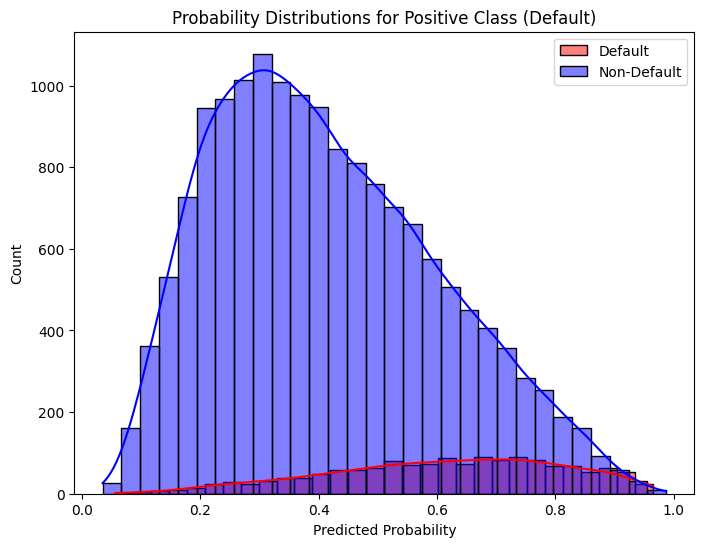

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot distribution of predicted probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_prob_log_reg[y_val == 1], color='r', label='Default', kde=True, bins=30)
sns.histplot(y_pred_prob_log_reg[y_val == 0], color='b', label='Non-Default', kde=True, bins=30)
plt.xlabel('Predicted Probability')
plt.title('Probability Distributions for Positive Class (Default)')
plt.legend()
plt.show()


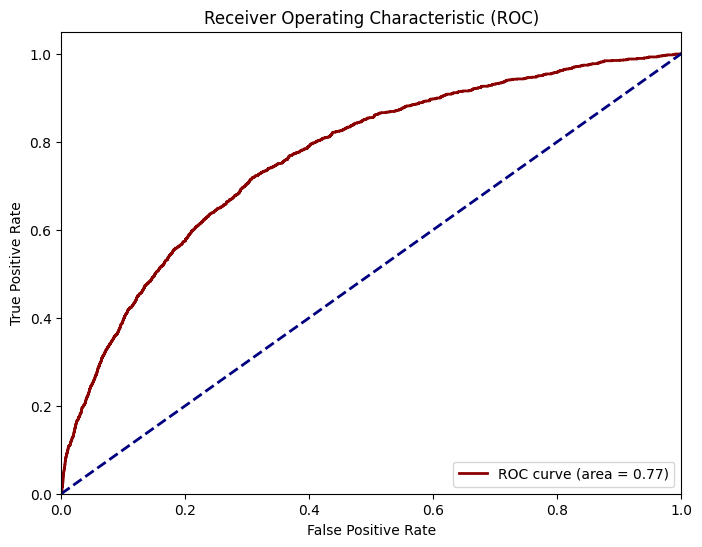

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_pred_prob_log_reg)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# META OVERSAMPLING

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from joblib import load, dump
from collections import Counter
import numpy as np
# Load the saved logistic regression base model
log_reg_model = load('log_reg_oversample_model.joblib')

# Separate features and target in the training set of the meta-model
X_meta_to_predict_on_1 = ap_val_df.drop(columns=['TARGET'])
y_val = ap_val_df["TARGET"]


# Generate predictions and probabilities on the validation set with the logistic regression model
log_reg_preds = log_reg_model.predict(X_meta_to_predict_on_1)
X_val_for_proba = X_meta_to_predict_on_1.copy()  # Copy for probability predictions

# Create target indicating False Positive (1 if False Positive, else 0)

X_meta_to_predict_on_1['false_positive_flag'] = ((log_reg_preds == 1) & (y_val == 0)).astype(int)
Y_meta_target_fp = X_meta_to_predict_on_1['false_positive_flag']

# Generate probability predictions for meta-model analysis (on the clean copy)
X_meta_to_predict_on_1['log_reg_pred_prob'] = log_reg_model.predict_proba(X_val_for_proba)[:, 1]

# Add binary predictions as meta-features
X_meta_to_predict_on_1['log_reg_pred'] = log_reg_preds  # Logistic regression binary prediction (0 or 1)

# 1. Log Odds: logit_prob = log(p / (1 - p)), where p is the predicted probability
X_meta_to_predict_on_1['logit_prob'] = np.log(X_meta_to_predict_on_1['log_reg_pred_prob'] / (1 - X_meta_to_predict_on_1['log_reg_pred_prob']))
# 2. Margin from Boundary: Absolute difference from 0.5
X_meta_to_predict_on_1['margin_from_boundary'] = np.abs(X_meta_to_predict_on_1['log_reg_pred_prob'] - 0.5)

# Filter data to only include cases where base model predicted 1 (potential defaulters)
X_meta_features_fp = X_meta_to_predict_on_1[X_meta_to_predict_on_1['log_reg_pred'] == 1].drop(columns=['false_positive_flag'])
Y_meta_target_fp = Y_meta_target_fp[X_meta_to_predict_on_1['log_reg_pred'] == 1]

# Oversample the minority class in the meta-model training set to balance false positives
oversampler = RandomOverSampler(random_state=42)
X_meta_features_fp_resampled, Y_meta_target_fp_resampled = oversampler.fit_resample(X_meta_features_fp, Y_meta_target_fp)
print("Distribution after oversampling:", Counter(Y_meta_target_fp_resampled))

# Define and train the meta-model
meta_model_log_reg = LogisticRegression(random_state=42, max_iter=1000, C=0.01, class_weight="balanced")
meta_model_log_reg.fit(X_meta_features_fp_resampled, Y_meta_target_fp_resampled)


# Save the Logistic Regression Meta-Model
dump(meta_model_log_reg, 'meta_model_log_reg_oversampling_fp.joblib')
print("Meta-model (targeting false positives) saved successfully!")

# Validation process for the meta-model on a separate validation set (meta_val_df)
y_val = meta_val_df["TARGET"]

# Separate features and target in the meta-validation set
X_meta_to_predict_on_2 = meta_val_df.drop(columns=['TARGET'])
y_meta_to_predict_on_2 = meta_val_df['TARGET']

# Generate predictions and probabilities with the logistic regression base model
log_reg_preds2 = log_reg_model.predict(X_meta_to_predict_on_2)
X_val_for_proba2 = X_meta_to_predict_on_2.copy()  # Copy for probability predictions

# Create target indicating False Positive (1 if False Positive, else 0)
X_meta_to_predict_on_2['false_positive_flag'] = ((log_reg_preds2 == 1) & (y_val == 0)).astype(int)

# Generate probability predictions for meta-model analysis
X_meta_to_predict_on_2['log_reg_pred_prob'] = log_reg_model.predict_proba(X_val_for_proba2)[:, 1]
# Add binary predictions as meta-features
X_meta_to_predict_on_2['log_reg_pred'] = log_reg_preds2  # Logistic regression binary prediction (0 or 1)
# 1. Log Odds: logit_prob = log(p / (1 - p)), where p is the predicted probability
X_meta_to_predict_on_2['logit_prob'] = np.log(X_meta_to_predict_on_2['log_reg_pred_prob'] / (1 - X_meta_to_predict_on_2['log_reg_pred_prob']))
# 2. Margin from Boundary: Absolute difference from 0.5
X_meta_to_predict_on_2['margin_from_boundary'] = np.abs(X_meta_to_predict_on_2['log_reg_pred_prob'] - 0.5)

# Filter validation data for cases where base model predicted 1
X_meta_features_val_fp = X_meta_to_predict_on_2[X_meta_to_predict_on_2['log_reg_pred'] == 1].drop(columns=['false_positive_flag'])
Y_meta_target_val_fp = X_meta_to_predict_on_2['false_positive_flag'][X_meta_to_predict_on_2['log_reg_pred'] == 1]

# Get predictions from the meta-model
log_reg_meta_pred_val = meta_model_log_reg.predict(X_meta_features_val_fp)
log_reg_meta_pred_prob_val = meta_model_log_reg.predict_proba(X_meta_features_val_fp)[:, 1]

# Calculate and display metrics for the logistic regression meta-model on validation set (false positives only)
log_reg_meta_auc_val = roc_auc_score(Y_meta_target_val_fp, log_reg_meta_pred_prob_val)
log_reg_meta_precision_val = precision_score(Y_meta_target_val_fp, log_reg_meta_pred_val)
log_reg_meta_recall_val = recall_score(Y_meta_target_val_fp, log_reg_meta_pred_val)
log_reg_meta_f1_val = f1_score(Y_meta_target_val_fp, log_reg_meta_pred_val)

print("\nFinal Evaluation for Logistic Regression Meta-Model on Meta-Validation Set (False Positives Only):")
print(f"AUC Score: {log_reg_meta_auc_val:.4f}")
print(f"Precision Score: {log_reg_meta_precision_val:.4f}")
print(f"Recall Score: {log_reg_meta_recall_val:.4f}")
print(f"F1 Score: {log_reg_meta_f1_val:.4f}")

X_meta_features_val_fp.shape


Distribution after oversampling: Counter({0: 4968, 1: 4968})
Meta-model (targeting false positives) saved successfully!

Final Evaluation for Logistic Regression Meta-Model on Meta-Validation Set (False Positives Only):
AUC Score: 0.6439
Precision Score: 0.8755
Recall Score: 0.6638
F1 Score: 0.7551


(2427, 44)

# BASELINE + META

In [18]:
import pandas as pd
from joblib import load
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Load base and meta-model
base_model = load('log_reg_oversample_model.joblib')
meta_model = load('meta_model_log_reg_oversampling_fp.joblib')

# Validation set setup
X_meta_val = meta_val_df.drop(columns=['TARGET'])
y_meta_val = meta_val_df['TARGET']

# Base model predictions and probabilities
base_preds = base_model.predict(X_meta_val)
base_pred_probs = base_model.predict_proba(X_meta_val)[:, 1]

# Create meta-features needed for meta-model
X_meta_val['log_reg_pred_prob'] = base_pred_probs
X_meta_val['log_reg_pred'] = base_preds
# 1. Log Odds: logit_prob = log(p / (1 - p)), where p is the predicted probability
X_meta_val['logit_prob'] = np.log(X_meta_val['log_reg_pred_prob'] / (1 - X_meta_val['log_reg_pred_prob']))
# 2. Margin from Boundary: Absolute difference from 0.5
X_meta_val['margin_from_boundary'] = np.abs(X_meta_val['log_reg_pred_prob'] - 0.5)




# Filter candidates where the base model predicted 1 (potential defaulters)
X_meta_val_fp_candidates = X_meta_val[base_preds == 1]

# Meta-model predictions for the candidates
meta_pred_probs = meta_model.predict_proba(X_meta_val_fp_candidates)[:, 1]

# Set correction threshold
fp_correction_threshold = 0.6# Adjust as needed

# Flagging high-confidence false positives
meta_flags = (meta_pred_probs >= fp_correction_threshold).astype(int)

# Apply corrections
final_preds = pd.Series(base_preds, index=X_meta_val.index)
corrected_indices = X_meta_val_fp_candidates.index[meta_flags == 1]
final_preds.loc[corrected_indices] = 0


# Evaluate final metrics
auc = roc_auc_score(y_meta_val, final_preds)
precision = precision_score(y_meta_val, final_preds, zero_division=1)
recall = recall_score(y_meta_val, final_preds, zero_division=1)
f1 = f1_score(y_meta_val, final_preds, zero_division=1)

print("\nFinal Evaluation with Meta-Model Correction:")
print(f"AUC Score: {auc:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Final Evaluation with Meta-Model Correction:
AUC Score: 0.6663
Precision Score: 0.2046
Recall Score: 0.5296
F1 Score: 0.2951


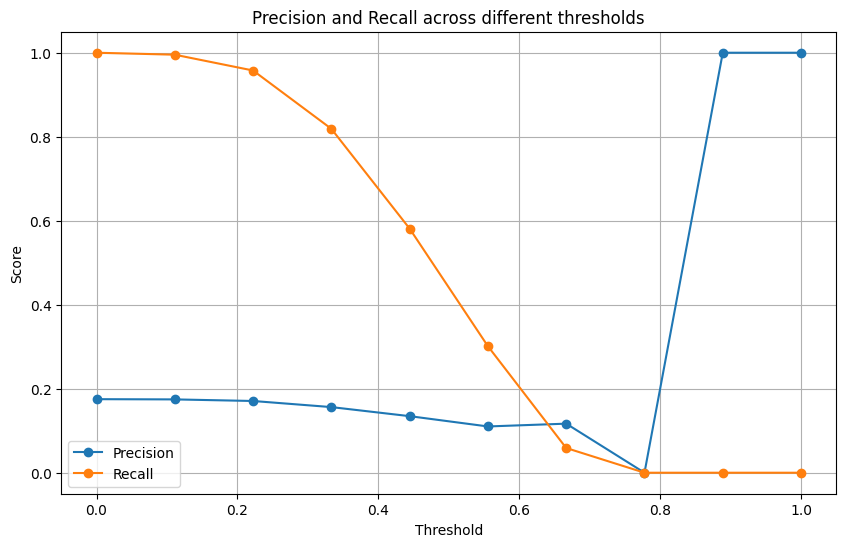

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Generate prediction probabilities for the meta-model on base model-predicted positives
meta_pred_probs = meta_model.predict_proba(X_meta_val_fp_candidates)[:, 1]

# Define a range of thresholds
thresholds = np.linspace(0, 1, 10)

# Lists to store precision and recall scores for each threshold
precision_scores = []
recall_scores = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Apply threshold to convert probabilities to binary predictions
    thresholded_preds = (meta_pred_probs >= threshold).astype(int)
    
    # Calculate precision and recall based on flagged false positives
    precision = precision_score(y_meta_val.loc[X_meta_val_fp_candidates.index], thresholded_preds, zero_division=1)
    recall = recall_score(y_meta_val.loc[X_meta_val_fp_candidates.index], thresholded_preds, zero_division=1)
    
    # Store the scores for plotting
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall across thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, marker='o', label="Precision")
plt.plot(thresholds, recall_scores, marker='o', label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall across different thresholds")
plt.legend()
plt.grid(True)
plt.show()


### Percentage Change from Baseline to Meta-Model Correction (Threshold = 0.5)

| Metric        | Baseline Logistic Regression (Oversampling) | Logistic Regression with Meta-Model Correction | % Change   |
|---------------|---------------------------------------------|-----------------------------------------------|------------|
| **AUC**       | 0.7617                                      | 0.6337                                        | -16.81%    |
| **Precision** | 0.1815                                      | 0.2596                                        | +43.04%    |
| **Recall**    | 0.6911                                      | 0.3676                                        | -46.82%    |
| **F1 Score**  | 0.2875                                      | 0.3043                                        | +5.84%     |

### Interpretation

- **Precision** increased by 43.04%, indicating improved control over false positives.
- **Recall** dropped significantly by 46.82%, reflecting fewer positive cases being identified.
- **AUC** decreased by 16.81%, showing reduced overall discrimination capability.
- **F1 Score** improved slightly by 5.84%, suggesting a better balance between precision and recall after applying meta-model correction.


### Percentage Change from Baseline to Meta-Model Correction (Threshold = 0.6)

| Metric        | Baseline Logistic Regression (Oversampling) | Logistic Regression with Meta-Model Correction | % Change   |
|---------------|---------------------------------------------|-----------------------------------------------|------------|
| **AUC**       | 0.7617                                      | 0.6663                                        | -12.53%    |
| **Precision** | 0.1815                                      | 0.2046                                        | +12.73%    |
| **Recall**    | 0.6911                                      | 0.5296                                        | -23.39%    |
| **F1 Score**  | 0.2875                                      | 0.2951                                        | +2.64%     |

### Interpretation

- **Precision** increased by 12.73%, indicating a modest improvement in controlling false positives.
- **Recall** decreased by 23.39%, reflecting a reduction in the number of true positives identified.
- **AUC** dropped by 12.53%, indicating a lower overall ability to distinguish between classes.
- **F1 Score** improved slightly by 2.64%, showing a marginally better balance between precision and recall at this threshold.


# Final Visualisations

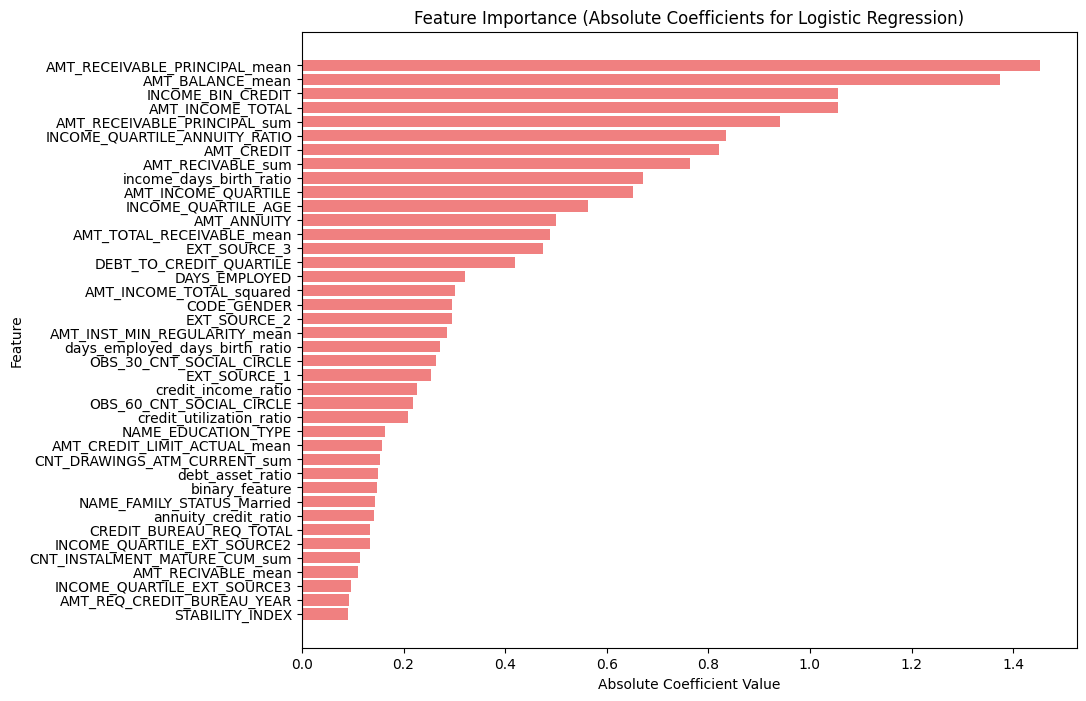

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate absolute values of coefficients and create DataFrame
features = X_train.columns
coefficients = np.abs(log_reg_model.coef_[0])  # Take absolute values

# Create a DataFrame for sorting
coef_df = pd.DataFrame({
    'Feature': features,
    'AbsCoefficient': coefficients
}).sort_values(by='AbsCoefficient', ascending=True)  # Sort for clear display

# Plot the absolute coefficients
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'], coef_df['AbsCoefficient'], color='lightcoral')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Absolute Coefficients for Logistic Regression)')
plt.show()




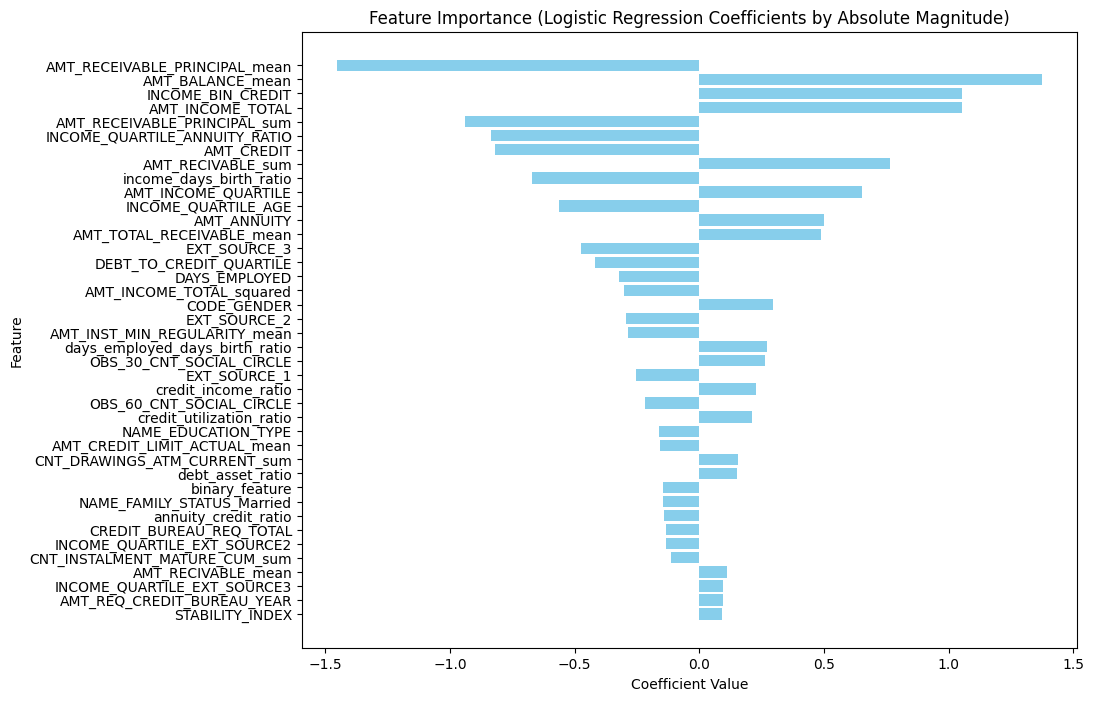

In [40]:


import matplotlib.pyplot as plt
import numpy as np

# Extract feature names and coefficients
features = X_train.columns
coefficients = log_reg_model.coef_[0]

# Create a DataFrame for features and their absolute coefficient values
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients)
})

# Sort by absolute value of coefficients
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Plot the coefficients sorted by absolute magnitude
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression Coefficients by Absolute Magnitude)')
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()
